In [2]:
import numpy as np
import pandas as pd
from pandas_datareader import data
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
faamg = ['FB','AAPL','AMZN','MSFT','GOOGL']

In [4]:
#substitute portfolio here and declare as port_list. The code reads port_list. 
port_list = faamg

In [5]:
#equal weight
# ew = {'FB': ew, 'AAPL': ew, 'AMZN': ew, 'MSFT': ew, 'GOOGL': ew}
ew = 1/len(port_list) 

In [7]:
#importing dividend data
div = pd.DataFrame()
for s in port_list:
    d = data.DataReader(s, 'yahoo-dividends', start='2019/12/31', end='2020/12/31')
    d['Ticker'] = s
    div = div.append(d)    
# div

In [133]:
# Import data
df = data.DataReader(port_list, 'yahoo', start='2019/12/31', end='2020/12/31')
df = df['Adj Close'] #to be dividend adjusted
# df2 = df.copy()

In [134]:
#dividend adjusted returns 
for i, row in div.iterrows():
    #print(i,row.Ticker, row.value)
    df[row.Ticker][df.index>=i] = df[row.Ticker][df.index>=i].apply(lambda x : x + row.value)

In [135]:
# Log of percentage change
cov_matrix = df.pct_change().apply(lambda x: np.log(1+x)).cov()
corr_matrix = df.pct_change().apply(lambda x: np.log(1+x)).corr()
# cov_matrix
# corr_matrix

In [136]:
# weighted portfolio's variance
port_var = cov_matrix.mul(ew, axis=0).mul(ew, axis=1).sum().sum()
port_var_ind = cov_matrix.mul(ew, axis=0).mul(ew, axis=1).sum()

In [137]:
# Yearly returns for individual companies
ind_er = df.resample('Y').last().pct_change().mean()

# Portfolio returns
port_er_ew = (ew*ind_er).sum()

# Volatility is given by the annual standard deviation. We multiply by 250 because there are 250 trading days/year.
ann_sd_ew = np.sqrt(port_var)
ann_sd_ew = ann_sd_ew*np.sqrt(250)

ann_sd_ew_ind = np.sqrt(port_var_ind)
ann_sd_ew_ind = ann_sd_ew_ind*np.sqrt(250)

In [138]:
assets = pd.concat([ind_er, ann_sd_ew_ind], axis=1) # Creating a table for visualising returns and volatility of assets
assets.columns = ['Returns', 'Volatility']
# assets

In [139]:
p_ret = [] # Define an empty array for portfolio returns
p_vol = [] # Define an empty array for portfolio volatility
p_weights = [] # Define an empty array for asset weights
num_assets = len(df.columns)
num_portfolios = 10_000

In [140]:
for portfolio in range(num_portfolios):
    weights = np.random.random(num_assets)
    weights = weights/np.sum(weights)
    p_weights.append(weights)
    returns = np.dot(weights, ind_er) # Returns = weights x expected returns                                     
    p_ret.append(returns)
    var = cov_matrix.mul(weights, axis=0).mul(weights, axis=1).sum().sum()# Portfolio Variance
    sd = np.sqrt(var) # Daily standard deviation
    ann_sd = sd*np.sqrt(250) # Annual standard deviation = volatility
    p_vol.append(ann_sd)

In [141]:
data = {'Returns':p_ret, 'Volatility':p_vol}
for counter, symbol in enumerate(df.columns.tolist()):
    #print(counter, symbol)
    data[symbol+' weight'] = [w[counter] for w in p_weights]

In [142]:
# Dataframe of the 10,000 portfolios of varying weights
portfolios  = pd.DataFrame(data)
# portfolios.head()

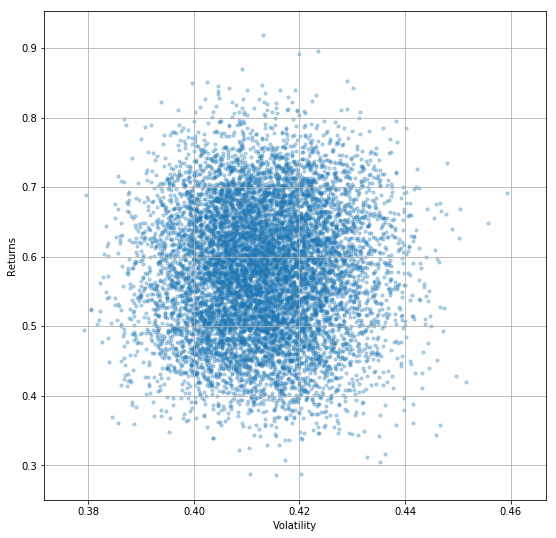

In [143]:
# # Plot efficient frontier
portfolios.plot.scatter(x='Volatility', y='Returns', marker='o', s=10, alpha=0.3, grid=True, figsize=[9,9])

In [144]:
# Finding the optimal portfolio via sharpe ratio
rf = 0.01 # risk factor
optimal_risky_port = portfolios.iloc[((portfolios['Returns']-rf)/portfolios['Volatility']).idxmax()]
#lowest weight should be ommited for next year
optimal_risky_port.sort_values(ascending=False).tail(10) #the lowest weight 10 stocks

DAL weight     0.004595
SAVE weight    0.004431
ISRG weight    0.004360
UPWK weight    0.003567
VTR weight     0.003331
PAYX weight    0.003244
AMT weight     0.001866
NCLH weight    0.000922
CCI weight     0.000921
O weight       0.000798
Name: 3161, dtype: float64

In [145]:
min_vol_port = portfolios.iloc[portfolios['Volatility'].idxmin()]                             
#lowest weight should be ommited for next year
min_vol_port.sort_values(ascending=False).tail(10) #the lowest weight 10 stocks

NVDA weight    0.006094
CRM weight     0.005296
PYPL weight    0.003364
MA weight      0.002754
JPM weight     0.002740
SAVE weight    0.002687
RDFN weight    0.002625
IIPR weight    0.002473
MDT weight     0.002012
ISRG weight    0.001342
Name: 4, dtype: float64

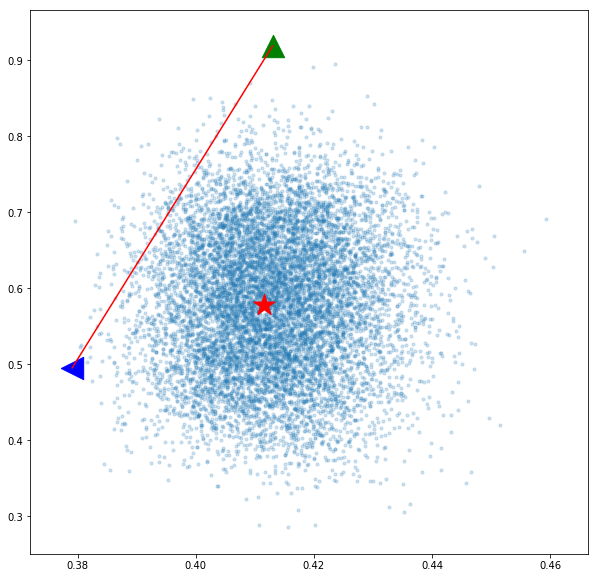

In [146]:
# Plotting optimal portfolio
plt.subplots(figsize=(10, 10))
plt.scatter(portfolios['Volatility'], portfolios['Returns'],marker='o', s=10, alpha=0.2)
plt.scatter(min_vol_port[1], min_vol_port[0], color='b', marker='<', s=500)
plt.scatter(optimal_risky_port[1], optimal_risky_port[0], color='g', marker='^', s=500)
plt.scatter(ann_sd_ew, port_er_ew, color='r', marker='*', s=500)
plt.plot([min_vol_port[1],optimal_risky_port[1]],[min_vol_port[0],optimal_risky_port[0]], color='r')

In [147]:
print('Equal weight portfolio variance: {} \nEqual weighted portfolio returns: {}'.format(ann_sd_ew, port_er_ew))

Equal weight portfolio variance: 0.41149946526967784 
Equal weighted portfolio returns: 0.5783688525838243


A good portfolio should be closer the red line. The red star is the equal weighted portfolio.

While guessing the weight of the stocks in the portfolio is difficult, we can actively ommit stocks from our equal weight strategy. If stocks exist in the lowest weight selection (lets say the worst 5) of both the optimal sharp ratio portfolio and the lowest variance portfolio, we can ommit the selected stocks and rerun the portfolio to see the results. Doing so can increase significantly the returns of our equal weight portfolio while trading off variance minimally.  